In [1]:
import random
from pathlib import Path
import re
import functools
import operator
import itertools
from typing import List, Optional, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torchtext
import torchtext.vocab
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")
torchtext.disable_torchtext_deprecation_warning()
warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

datapath = Path.cwd().parent / 'data' / 'fake_and_real_news_dataset.csv'


def get_sentences(datapath: Path) -> pd.Series:
    sentences = pd.read_csv(str(datapath))
    sentences = sentences["title"]
    sentences = sentences.dropna()
    sentences = sentences.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    sentences = sentences.apply(lambda x: re.sub(r'\b[b-hj-z]\b', ' ', x)) # floating single letters except 'a', 'i'    
    return sentences


sentences = get_sentences(datapath)
tokenizer = get_tokenizer('basic_english')
tokenized_sentences = sentences.apply(tokenizer)

features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_sentences,
    min_freq=2, # minimum frequency of a word to be included in the vocabulary
    specials=['<pad>', '<oov>'], # pad = padding, oov = out of vocabulary
    special_first=True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_sentences,
    min_freq=2
)


def get_ngram_encoding(tokenized_sentences: List[str]) -> Tuple[List[List[int]], List[int]]:
    # get ngrams of tokenized sentences and encode them to vocabulary indices

    def _get_ngrams(tokenized_sentence: List[str]) -> List[List[str]]:
        # example: "hello beautiful world" -> ["hello", "hello beautiful", "hello beautiful world"]
        list_ngrams = []
        for i in range(1, len(tokenized_sentence)):
            ngram_sequence = tokenized_sentence[:i+1]
            list_ngrams.append(ngram_sequence)
        return list_ngrams

    def _insert_oovs(ngram: List[str]) -> List[str]:
        # replace 10% of tokens with <oov> token to simulate the presence of out-of-vocabulary words    
        for idx, _ in enumerate(ngram[:-1]):
            if random.uniform(0, 1) < 0.1:
                ngram[idx] = '<oov>'
        return ngram

    def _encode_to_vocab_idx(tokenized_sentence: List[str]) -> Optional[List[int]]:
        # encode by replacing each token with its index in the vocabulary
        tokens_list = []
        if tokenized_sentence[-1] in target_vocab.get_itos(): # get_itos() = get index to string
            for token in tokenized_sentence[:-1]:
                num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>'] # features from features_vocab
                tokens_list.append(num_token)
            num_token = target_vocab[tokenized_sentence[-1]] # target (last token) from target_vocab
            tokens_list.append(num_token)
            return tokens_list
        
        # target token is not in the vocabulary
        return None

    flatmap = lambda f, items: functools.reduce(operator.iconcat, map(f, items), [])

    ngrams_list = flatmap(_get_ngrams, tokenized_sentences)
    ngrams_list_oov = list(map(_insert_oovs, ngrams_list))
    input_sequences = list(filter(None, map(_encode_to_vocab_idx, ngrams_list_oov)))

    X = [seq[:-1] for seq in input_sequences] # type: ignore
    y = [seq[-1] for seq in input_sequences] # type: ignore
    return X, y


X, y = get_ngram_encoding(tokenized_sentences)
longest_sequence_feature = max(len(x) for x in X)
padded_X = [F.pad(torch.tensor(x), (longest_sequence_feature - len(x), 0), value=0) for x in X] # <--- try to shove this into encoder as well
longest_sequence_feature_v2 = max(len(x) for x in X)

print(f"Longest sequence feature: {longest_sequence_feature}")
print(f"Longest sequence feature v2: {longest_sequence_feature_v2}")

/Users/sueszli/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/sueszli/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/sueszli/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/torchtext/data/__i

In [2]:
class Autocompleter(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim, dropout_prob):
        super(Autocompleter, self).__init__()

        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x) # convert indices to dense vectors
        lstm_out, _ = self.lstm(embedded) # LSTM layer
        lstm_out = self.dropout(lstm_out) # dropout layer: randomly zero out elements of the input tensor with probability p
        output = self.fc(lstm_out[:, -1, :]) # fully connected layer: map the output of the LSTM layer to the output vocabulary
        return output

embedding_dim = longest_sequence_feature
hidden_dim = 200
epochs = 50
dropout_prob = 0.5

model = Autocompleter(len(features_vocab), len(target_vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, dropout_prob=dropout_prob)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)





def predict(model, data_loader, k=3):
    # get top-k accuracy of the model on the given data
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            output = model(batch_x)

            # Get top-k predictions
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k predictions
            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy




padded_X = torch.stack(padded_X)
y = torch.tensor(y)

y_one_hot = one_hot(y, num_classes=len(target_vocab))

data = TensorDataset(padded_X, y_one_hot)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 32
train_data, test_data = random_split(data, [train_size, test_size])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


all_accuracies = []
all_losses = []
for epoch in tqdm(range(epochs)):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()
            
    if epoch % 5 == 0:
        accuracy = predict(model, train_loader)
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Train K-Accuracy: {accuracy * 100:.2f}%')
        all_accuracies.append(accuracy)
        all_losses.append(loss.item())


  2%|▏         | 1/50 [00:08<06:46,  8.29s/it]

Epoch 0/50, Loss: 6.7502, Train K-Accuracy: 10.65%


 12%|█▏        | 6/50 [00:37<04:38,  6.33s/it]

Epoch 5/50, Loss: 6.6401, Train K-Accuracy: 24.09%


 22%|██▏       | 11/50 [01:06<04:03,  6.24s/it]

Epoch 10/50, Loss: 5.0055, Train K-Accuracy: 49.52%


 32%|███▏      | 16/50 [01:37<03:48,  6.73s/it]

Epoch 15/50, Loss: 3.7347, Train K-Accuracy: 67.73%


 42%|████▏     | 21/50 [02:09<03:17,  6.82s/it]

Epoch 20/50, Loss: 3.1401, Train K-Accuracy: 78.09%


 52%|█████▏    | 26/50 [02:40<02:49,  7.06s/it]

Epoch 25/50, Loss: 2.4343, Train K-Accuracy: 83.66%


 62%|██████▏   | 31/50 [03:14<02:22,  7.50s/it]

Epoch 30/50, Loss: 1.5598, Train K-Accuracy: 87.08%


 72%|███████▏  | 36/50 [03:46<01:41,  7.22s/it]

Epoch 35/50, Loss: 2.6170, Train K-Accuracy: 89.20%


 82%|████████▏ | 41/50 [04:20<01:04,  7.22s/it]

Epoch 40/50, Loss: 1.8536, Train K-Accuracy: 90.59%


 92%|█████████▏| 46/50 [04:53<00:28,  7.16s/it]

Epoch 45/50, Loss: 2.1824, Train K-Accuracy: 91.23%


100%|██████████| 50/50 [05:17<00:00,  6.35s/it]


# benchmark

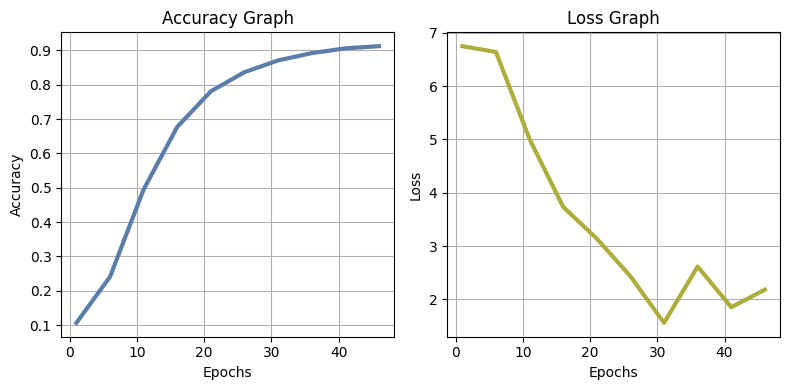

In [3]:
epoch_list = [i for i in range(1,epochs,5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) 

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)
 
axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [4]:
accuracy = predict(model, test_loader)
print(f'Test K-Accuracy: {accuracy * 100:.2f}%')

Test K-Accuracy: 16.60%


In [5]:
def text_to_numerical_sequence_test(tokenized_text):
    tokens_list = []
    for token in tokenized_text:
        num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
        tokens_list.append(num_token)
    return tokens_list


def use_model(input_list):
    model.eval()
    
    output_list = []
    for data in input_list:
        sentence = data[0]
        num_words = data[1]
        for _ in range(num_words):
            output_of_model = []
            tokenized_input_test = tokenizer(sentence)
            tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
            padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test), (longest_sequence_feature - len(tokenized_sequence_input_test)-1, 0), value=0)
            output_test_walking = torch.argmax(model(padded_tokenized_sequence_input_test.unsqueeze(0)))
            sentence = sentence + ' ' + target_vocab.lookup_token(output_test_walking.item()) # type: ignore
        output_list.append(sentence)
    return output_list

input_test = [['why', 19], ['trump', 10], ['this is', 4], ['6 ways', 3], ['you did a', 10]]
outputs_model = use_model(input_test)
outputs_model

['why trump is a risk for the election because of a moscow beijing holds drills video percentfedup com my future',
 'trump and sanders win the vote for the election year in',
 'this is why the republican party',
 '6 ways to eat with',
 'you did a warning being college with it a man who and the']